In [24]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD
# !pip install requirements.txt

In [25]:
import numpy as np

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.models as models
import src.losses as loss

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [27]:
if 'google.colab' in str(get_ipython()):
  use_colab = True
  print('Running on CoLab')
else:
  use_colab = False
  print('Not running on CoLab')

Not running on CoLab


### If you already have a patch folder use `source_dir=./your_patch_folder`, otherwise use `source_dir=None`

In [28]:
source_dir = None#'./data/training/patches'

if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/560Mhz_1000h.fits"
    config.TRAIN_DATA_FOLDER = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset"
    config.TRAIN_PATCHES_FOLDER = "/content/drive/My Drive/Colab Notebooks/SKADC1/patches"
    source_dir = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/patches"

In [29]:
# Choose the feature extraction model
# backbone='baseline_44'
# backbone='baseline_16'
backbone='vgg16'

if backbone=='baseline_16':
    # config.patch_dim = 50
    config.patch_dim = 20
    config.resizePatch = True
    config.rpn_stride = 4
    config.num_rois = 16
    # config.anchor_box_scales = [8, 16, 32, 64] # anchors in the original image size
    config.anchor_box_scales = [4, 8, 16, 24, 32, 64] # anchors in the original image size
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
elif backbone=='baseline_44':
    config.patch_dim = 20
    config.resizePatch = True
    config.rpn_stride = 8
    config.num_rois = 16
    config.anchor_box_scales = [4, 8, 16, 24, 32, 64]
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
else:
    config.patch_dim = 100
    config.resizePatch = True
    config.rpn_stride = 16
    config.num_rois = 16
    config.resizeFinalDim = 600
    input_shape_1=config.resizeFinalDim
    config.anchor_box_scales = [32,64,128]
    config.in_out_img_size_ratio = config.rpn_stride

config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
input_shape_2=(None, 4)
use_focal_loss = True

checkpoint = get_model_last_checkpoint(backbone)
print(f'Model last checkpoint: {checkpoint}')

file_path = f'{config.MODEL_WEIGHTS}/{backbone}'
print(f'Writing configuration on txt file: {config.MODEL_WEIGHTS}/config.txt')

if not os.path.exists(file_path):
        os.makedirs(file_path)
        
f = open(f'{file_path}/config.txt',"w+")
f.write(f'backbone = {backbone}\n config.patch_dim = {config.patch_dim}\n config.resizePatch = {config.resizePatch}\n config.rpn_stride = {config.rpn_stride}\n config.num_rois = {config.num_rois}\n config.anchor_box_scales = {config.anchor_box_scales}\n config.resizeFinalDim = {config.resizeFinalDim}\n input_shape_1 = {input_shape_1}')
f.close()

Checking model checkpoints in directory /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/vgg16
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/vgg16/map_24_frcnn_vgg16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/vgg16/loss_0_frcnn_vgg16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/vgg16/loss_1_frcnn_vgg16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/vgg16/map_10_frcnn_vgg16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/vgg16/loss_2_frcnn_vgg16.h5
Model last checkpoint: map_24_frcnn_vgg16.h5
Writing configuration on txt file: /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/config.txt


Dataset shape: (19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


  0%|          | 0/19222 [00:00<?, ?it/s]

Loading FITS file /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/data/training/560Mhz_1000h.fits


100%|██████████| 19222/19222 [00:02<00:00, 7125.51it/s]


Initial dataset shape: (19222, 15)
Found 0 boxes with zero area
Rows to be deleted: 0
New dataset shape: (19222, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (19222, 26)

Enlarging bboxes...
DONE - Enlarging bboxes...


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped,class_label
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,19710.764566,17719.170105,6.264429,6.218255,5.734349,12.503792,12.461712,155.818657,155.818657,1_1
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,18509.603417,17209.564571,110.037236,44.503323,3.338082,216.538139,97.294352,21067.937901,21067.937901,1_1
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,16498.009965,18512.295208,5.738106,4.389739,4.827354,8.820318,11.444852,100.947234,100.947234,1_1
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18023.322729,18184.661968,3.031418,2.541842,6.050027,6.014593,5.140670,30.919039,30.919039,2_1
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18128.789688,18604.884928,4.236891,2.929772,4.869573,5.937378,8.419429,49.989332,49.989332,1_1



----------
Starting training image preprocessing...

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0065856808796525
Min pixel value = -1.9004022533408715e-06
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

Mean and stdev of the half-gaussian that best fits with noise distribution:
mu=4.561610766868865e-14, stdev=4.5037468510513567e-07
End of training image preprocessing.


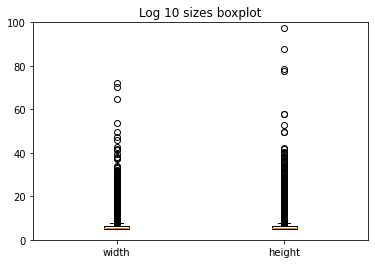

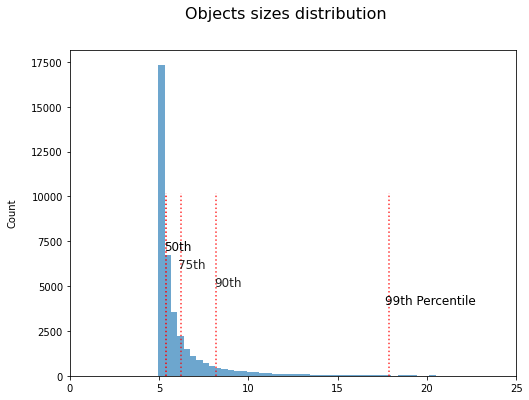

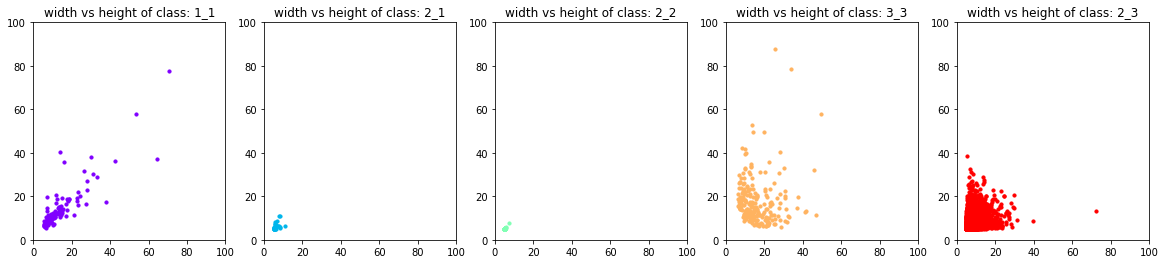

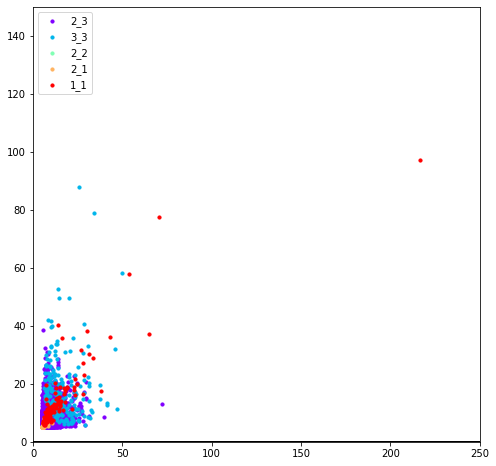

In [30]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(print_info=False, show_plot=True)

In [31]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig', 'area_cropped']].describe()

,width,height,area_orig,area_cropped
count,19222.000000,19222.000000,19222.000000,19222.000000
mean,6.282190,6.285123,44.731314,44.731314
std,3.122242,2.910949,169.529219,169.529219
min,4.964839,4.964839,24.649628,24.649628
25%,5.114121,5.116855,26.770928,26.770928
50%,5.388071,5.394034,29.928541,29.928541
75%,6.193903,6.206960,39.145862,39.145862
max,216.538139,97.294352,21067.937901,21067.937901


In [32]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig']].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99,1.])

,width,height,area_orig
0.10,5.021579,5.022318,25.628098
0.20,5.079478,5.083666,26.354817
0.30,5.153434,5.154979,27.221580
0.40,5.250224,5.256348,28.358833
0.50,5.388071,5.394034,29.928541
0.60,5.596149,5.603978,32.164977
0.70,5.931373,5.932616,36.070023
0.80,6.568193,6.603042,43.494231
0.90,8.241342,8.188366,63.754795
0.95,10.577456,10.646052,100.988437


In [33]:
objects_to_ignore=[20167150, 27514971]

In [34]:
# Use at max limit=3969 for vgg16

ska_dataset.generate_patches(limit=10000, plot_patches=False, objects_to_ignore=objects_to_ignore, source_dir=source_dir, rgb_norm=True)

 39%|███▉      | 39/100 [45:02<1:13:10, 71.98s/it]


 Generating patch 2623/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.4768947696429677e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1209_16376_18679_100 saved.

 Generating patch 2624/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.4768947696429677e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1210_16426_18679_100 saved.

 Generating patch 2625/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.440732168906834e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1211_16476_18679_100 saved.

 Generating patch 2626/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.440732168906834e-05
Removin

 40%|████      | 40/100 [46:13<1:11:34, 71.58s/it]


 Generating patch 2691/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.4870503693819046e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1240_16376_18729_100 saved.

 Generating patch 2692/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.0983643480576575e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1241_16426_18729_100 saved.

 Generating patch 2693/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.440732168906834e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1242_16476_18729_100 saved.

 Generating patch 2694/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.440732168906834e-05
Removin

 41%|████      | 41/100 [47:37<1:14:16, 75.54s/it]


 Generating patch 2759/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.4870503693819046e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1271_16376_18779_100 saved.

 Generating patch 2760/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.745372537698131e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1272_16426_18779_100 saved.

 Generating patch 2761/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.2281154340598732e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1273_16476_18779_100 saved.

 Generating patch 2762/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.12928619273589e-05
Removing

 42%|████▏     | 42/100 [49:05<1:16:35, 79.24s/it]


 Generating patch 2827/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2655456632492132e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1302_16376_18829_100 saved.

 Generating patch 2828/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2655456632492132e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1303_16426_18829_100 saved.

 Generating patch 2829/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.2281154340598732e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1304_16476_18829_100 saved.

 Generating patch 2830/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.395985888550058e-05
Removi

 43%|████▎     | 43/100 [50:17<1:13:07, 76.98s/it]


 Generating patch 2895/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2655456632492132e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1333_16376_18879_100 saved.

 Generating patch 2896/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2655456632492132e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1334_16426_18879_100 saved.

 Generating patch 2897/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.1706202712957747e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1335_16476_18879_100 saved.

 Generating patch 2898/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.395985888550058e-05
Removi

 44%|████▍     | 44/100 [51:22<1:08:28, 73.37s/it]


 Generating patch 2963/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 9.40616155276075e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1364_16376_18929_100 saved.

 Generating patch 2964/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2005531718605198e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1365_16426_18929_100 saved.

 Generating patch 2965/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2005531718605198e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1366_16476_18929_100 saved.

 Generating patch 2966/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.1795727661810815e-05
Removin

 45%|████▌     | 45/100 [52:30<1:05:48, 71.80s/it]


 Generating patch 3031/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 9.40616155276075e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1395_16376_18979_100 saved.

 Generating patch 3032/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.3347794922301546e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1396_16426_18979_100 saved.

 Generating patch 3033/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.0129358239937574e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1397_16476_18979_100 saved.

 Generating patch 3034/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.0129358239937574e-05
Removin

 46%|████▌     | 46/100 [53:40<1:04:08, 71.28s/it]


 Generating patch 3099/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.1953250325168483e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1426_16376_19029_100 saved.

 Generating patch 3100/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.00017695462156552821
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1427_16426_19029_100 saved.

 Generating patch 3101/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.00017695462156552821
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1428_16476_19029_100 saved.

 Generating patch 3102/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.0129358239937574e-05
Remov

 47%|████▋     | 47/100 [54:49<1:02:15, 70.48s/it]


 Generating patch 3167/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.945293039781973e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1457_16376_19079_100 saved.

 Generating patch 3168/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.00017695462156552821
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1458_16426_19079_100 saved.

 Generating patch 3169/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.00017695462156552821
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1459_16476_19079_100 saved.

 Generating patch 3170/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.07201589748729e-05
Removing

 48%|████▊     | 48/100 [56:03<1:02:00, 71.54s/it]


 Generating patch 3235/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.945293039781973e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1488_16376_19129_100 saved.

 Generating patch 3236/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 9.066878556041047e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1489_16426_19129_100 saved.

 Generating patch 3237/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001800340978661552
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1490_16476_19129_100 saved.

 Generating patch 3238/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001800340978661552
Removing 

 49%|████▉     | 49/100 [57:13<1:00:34, 71.26s/it]


 Generating patch 3303/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 6.299722008407116e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1519_16376_19179_100 saved.

 Generating patch 3304/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 6.299722008407116e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1520_16426_19179_100 saved.

 Generating patch 3305/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001800340978661552
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1521_16476_19179_100 saved.

 Generating patch 3306/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001800340978661552
Removing 

 50%|█████     | 50/100 [58:22<58:39, 70.40s/it]  


 Generating patch 3371/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.00010203754209214821
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1550_16376_19229_100 saved.

 Generating patch 3372/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 6.299722008407116e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1551_16426_19229_100 saved.

 Generating patch 3373/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.992352816974744e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1552_16476_19229_100 saved.

 Generating patch 3374/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.992352816974744e-05
Removing

 51%|█████     | 51/100 [59:27<56:15, 68.88s/it]


 Generating patch 3439/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.00010203754209214821
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1581_16376_19279_100 saved.

 Generating patch 3440/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 4.784324482898228e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1582_16426_19279_100 saved.

 Generating patch 3441/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.992352816974744e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1583_16476_19279_100 saved.

 Generating patch 3442/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.992352816974744e-05
Removing

 52%|█████▏    | 52/100 [1:00:32<54:12, 67.76s/it]


 Generating patch 3507/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001840421318775043
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1612_16376_19329_100 saved.

 Generating patch 3508/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001840421318775043
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1613_16426_19329_100 saved.

 Generating patch 3509/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.296279308211524e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1614_16476_19329_100 saved.

 Generating patch 3510/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 9.765155118657276e-05
Removing 

 53%|█████▎    | 53/100 [1:01:45<54:13, 69.22s/it]


 Generating patch 3575/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001840421318775043
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1643_16376_19379_100 saved.

 Generating patch 3576/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0001840421318775043
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1644_16426_19379_100 saved.

 Generating patch 3577/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.296279308211524e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1645_16476_19379_100 saved.

 Generating patch 3578/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 9.765155118657276e-05
Removing 

 54%|█████▍    | 54/100 [1:02:55<53:21, 69.59s/it]


 Generating patch 3643/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.3672630049986765e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1674_16376_19429_100 saved.

 Generating patch 3644/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.3672630049986765e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1675_16426_19429_100 saved.

 Generating patch 3645/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.467481292318553e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1676_16476_19429_100 saved.

 Generating patch 3646/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.467481292318553e-05
Removin

 55%|█████▌    | 55/100 [1:04:00<51:08, 68.18s/it]


 Generating patch 3711/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.628825339139439e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1705_16376_19479_100 saved.

 Generating patch 3712/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.5177135537669528e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1706_16426_19479_100 saved.

 Generating patch 3713/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.467481292318553e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1707_16476_19479_100 saved.

 Generating patch 3714/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 7.897100294940174e-05
Removing

 56%|█████▌    | 56/100 [1:05:05<49:16, 67.20s/it]


 Generating patch 3779/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.662384137394838e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1736_16376_19529_100 saved.

 Generating patch 3780/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.662384137394838e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1737_16426_19529_100 saved.

 Generating patch 3781/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.3025378797901794e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1738_16476_19529_100 saved.

 Generating patch 3782/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 7.897100294940174e-05
Removing

 57%|█████▋    | 57/100 [1:06:11<47:48, 66.70s/it]


 Generating patch 3847/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.662384137394838e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1767_16376_19579_100 saved.

 Generating patch 3848/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.662384137394838e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1768_16426_19579_100 saved.

 Generating patch 3849/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.186177127645351e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1769_16476_19579_100 saved.

 Generating patch 3850/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.543176353559829e-05
Removing 

 58%|█████▊    | 58/100 [1:07:15<46:15, 66.07s/it]


 Generating patch 3915/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.9098337361356243e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1798_16376_19629_100 saved.

 Generating patch 3916/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.9098337361356243e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1799_16426_19629_100 saved.

 Generating patch 3917/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.4105636081658304e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1800_16476_19629_100 saved.

 Generating patch 3918/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.4105636081658304e-05
Remov

 59%|█████▉    | 59/100 [1:08:20<44:53, 65.68s/it]


 Generating patch 3983/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.9098337361356243e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1829_16376_19679_100 saved.

 Generating patch 3984/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.448097049840726e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1830_16426_19679_100 saved.

 Generating patch 3985/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 5.4105636081658304e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1831_16476_19679_100 saved.

 Generating patch 3986/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 7.803788321325555e-05
Removin

 60%|██████    | 60/100 [1:09:24<43:30, 65.26s/it]


 Generating patch 4051/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.7133354049292393e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1860_16376_19729_100 saved.

 Generating patch 4052/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.448097049840726e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1861_16426_19729_100 saved.

 Generating patch 4053/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.448097049840726e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1862_16476_19729_100 saved.

 Generating patch 4054/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 7.803788321325555e-05
Removing

 61%|██████    | 61/100 [1:10:29<42:16, 65.05s/it]


 Generating patch 4119/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.3490585843101144e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1891_16376_19779_100 saved.

 Generating patch 4120/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.855210525216535e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1892_16426_19779_100 saved.

 Generating patch 4121/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.855210525216535e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...
Patch 1893_16476_19779_100 saved.

 Generating patch 4122/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.890159910544753e-05
Removing

 62%|██████▏   | 62/100 [1:11:34<41:08, 64.96s/it]


 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2078840629546903e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.855210525216535e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 3.855210525216535e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.7979373296839185e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

 

 63%|██████▎   | 63/100 [1:12:30<38:33, 62.52s/it]


 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.2078840629546903e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.8106082027079538e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 2.8106082027079538e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

 Generating patch 4187/10000

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 1.7979373296839185e-05
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...


100%|██████████| 100/100 [1:27:54<00:00, 52.74s/it]


Patches with no gt: 5522
Patches skipped due to ignore objects list: 26
Total number of generated patches: 4186

Class list: ['2_3' '2_2' '3_3' '2_1' '1_1']
Number of distinct class labels: 5


Train list consists of 280 patches
Val list consists of 70 patches


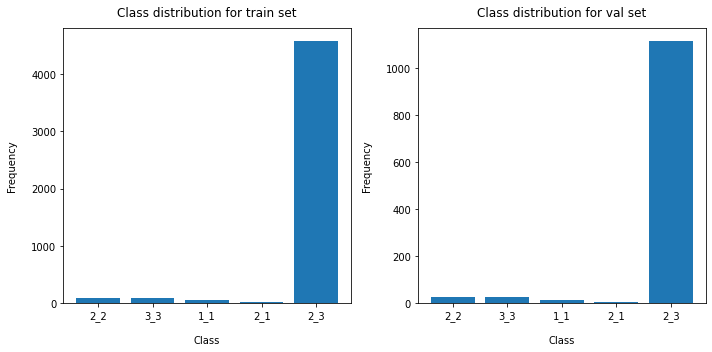

In [35]:
# Use seed=5 for 20_100 and 100_600 sets and seed=15 for 50_100
ska_dataset.split_train_val(random_state=5, val_portion=0.2, balanced=False, size=350)

# Training

### Get FRCNN model

In [ ]:
rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

### Load weights

In [ ]:
checkpoint= 'loss_0_frcnn_baseline_16.h5'
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False, checkpoint=checkpoint)

if use_focal_loss:
    models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.categorical_focal_loss(config.alpha, config.gamma), loss.detector_loss_regr], class_list=ska_dataset.class_list)
else:
    models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)


In [ ]:
# If you want to specifically check backbone weights you need to slice weights tensors like this:
# total_model.weights[24:25][0][0][0][0]

In [ ]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

In [ ]:
# Generating validation model for validation step at epoch's end
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

In [ ]:
from src.train import *

train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, rpn_model_eval, detector_model_eval, total_model_eval, ska_dataset.val_patch_list, ska_dataset.class_list, num_epochs=120, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)

# Validation

In [36]:
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)  

In the following cell please select weights to be used to perform model evaluation

In [37]:
cp = 'map_24_frcnn_vgg16.h5'

In [38]:
# Models used for mAP eval
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=cp)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [ ]:
plist = ['162_18276_16929_100', '735_17476_17879_100', '401_17826_17329_100']

preds, mAP, mPrecision, mRecall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, plist, ska_dataset.class_list, map_threshold=.5, acceptance_treshold=.5, save_eval_results=True)

In [ ]:
# Evaluation step carried out on the entire validation set

preds, mAP, mPrecision, mRecall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, ska_dataset.val_patch_list, ska_dataset.class_list, map_threshold=.5, acceptance_treshold=.5, save_eval_results=False)

In [40]:
# Evaluation step carried out on the entire training set

preds, mAP, mPrecision, mRecall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, ska_dataset.train_patch_list, ska_dataset.class_list, map_threshold=.5, acceptance_treshold=.5, save_eval_results=False)

100%|██████████| 280/280 [05:26<00:00,  1.17s/it]


Total model metrics: mAP: 27.22% - mPrecision: 1.01% - mRecall: 1.46%


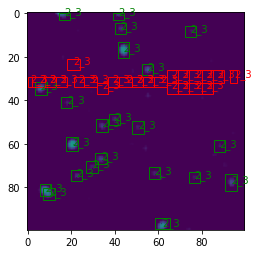

In [45]:
# Qualitative evaluation by printing image, ground truth and predicted bounding boxes
# patches used in the report for the 20_100 set: 14003_16486_17609_20, 8769_16616_17279_20, 14365_16926_17629_20
# patches used in the report for the 50_100 set: 
# patches used in the report for the 100_600 set: 162_18276_16929_100, 735_17476_17879_100, 401_17826_17329_100
patch = '401_17826_17329_100'

print_img(config.TRAIN_PATCHES_FOLDER, patch, config.EVAL_RESULTS, show_data=False)

# Plotting

### Loss plot

In [ ]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)
plot_loss(loss_history[:])

### Evaluation metrics plot

In [ ]:
scores_history = np.load(f"./model/{backbone}/scores_history.npy")
print(scores_history.shape)
plot_scores(scores_history[:])


In [ ]:
lsma_0 = moving_average(loss_history[100:,2], 200)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, len(lsma_0)), lsma_0, 'r')
plt.title('rpn cls')
